# Libraries Import

In [2]:
# for working with dataframes, CSV
import pandas as pd

# for working with twitter API
import tweepy

# for working with wrapping python codes into SQL queries
import sqlalchemy as db

# for getting current date and time for CSV file creation
from datetime import datetime

# for keeping credentials out of sight
import os
from dotenv import load_dotenv

# for sentiment analysis
from textblob import TextBlob

# for stopwords
import nltk
from nltk.corpus import stopwords
import itertools
import collections

# For generating word cloud
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np

# for plotting wordcloud and sentiments analysis pie chart
import matplotlib.pyplot as plt
from PIL import Image

# Credentials and Authorization

In [3]:
# establish working directory path
# getcwd() returns current working directory
wdir_path = os.getcwd()

### Twitter Credentials

In [4]:
# create a "twitter-keys.env" file under the script working directory
# fill in personal api keys and access tokens and save

twitter_path = os.path.join(wdir_path, "twitter-keys.env") # absolute path of "twitter-keys.env"
# load the credentials into os environment 
load_dotenv(twitter_path)
#check if credentials loaded successfully
os.environ


# Credentials obtained from twitter developer account to access API
# getting api_keys & access_tokens from "twitter-keys.env"
consumer_key = os.getenv("consumer_key")
consumer_secret = os.getenv("consumer_secret")
access_key = os.getenv("access_key")
access_secret = os.getenv("access_secret")

# setup Twitter API connection details
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

### SQL Credentials

In [5]:
# create a "sql-keys.env" file under the script working directory
# fill in personal api keys and access tokens and save
sql_path = os.path.join(wdir_path, "sql-keys.env") # absolute path of "sql-keys.env"
# load the credentials into os environment 
load_dotenv(sql_path)
#check if credentials loaded successfully
os.environ

# getting credentials information from "sql-keys.env"
user = os.getenv("dbUser")
password = os.getenv("dbPwd")
hostname = os.getenv("dbHost")
port_no = os.getenv("dbPort")
db_name = os.getenv("dbName")

# setup connection engine details
engine = db.create_engine(f"postgresql://{user}:{password}@{hostname}:{port_no}/{db_name}")  

# Create Table in PostgreSQL

In [6]:
# Create connection engine
conn = engine.raw_connection()

# Create new tables in PostgreSQL
commands = ("""CREATE TABLE IF NOT EXISTS twitterDatabase (tweet_id BIGINT PRIMARY KEY,
                                                           username VARCHAR(15),
                                                           display_name TEXT,
                                                           location TEXT,
                                                           followers_count INTEGER,
                                                           following_count INTEGER,
                                                           tweet_text TEXT,
                                                           hashtags TEXT,
                                                           polarity NUMERIC(3,2),
                                                           subjectivity NUMERIC(3,2));""")

# Initialize connection to PostgreSQL
cur = conn.cursor()
table_count = 0

# Create cursor to execute SQL commands
cur.execute(commands)
table_count += 1

# Close communication with server
conn.commit()
cur.close()
conn.close()

print(str(table_count),"table(s) have been created in PostgreSQL.")

1 table(s) have been created in PostgreSQL.


# Data Extraction

Creation of queries using Tweepy API

Function is focused on completing the query then providing a CSV file of that query using pandas

And then inserting the data directly into PostgreSQL database

In [7]:
# function to display data of each tweet
def printtweetdata(n, ith_tweet):
        print()
        print(f"====Tweet {n}====")
        print(f"Tweet ID:{ith_tweet[0]}")
        print(f"Userame:{ith_tweet[1]}")
        print(f"Display Name:{ith_tweet[2]}")
        print(f"Location:{ith_tweet[3]}")
        print(f"Follower Count:{ith_tweet[4]}")
        print(f"Following Count:{ith_tweet[5]}")
        print(f"Tweet Text:{ith_tweet[6]}")
        print(f"Hashtags Used:{ith_tweet[7]}")
        print(f"Polarity:{ith_tweet[8]}")
        print(f"Subjectivity:{ith_tweet[9]}")

# function to perform data extraction
def scrape(words, numtweet):

        # Creating DataFrame using pandas
        global tweetsDF
        tweetsDF = pd.DataFrame(columns=["tweet_id",
                                   "username",
                                   "display_name",
                                   "location",
                                   "followers",
                                   "following",
                                   "text",
                                   "hashtags",
                                   'polarity',
                                   'subjectivity'])

        # We are using .Cursor() to search through twitter for the required tweets.
        # The number of tweets can be restricted using .items(number of tweets)
        if inp == "1": # if user input to search using hashtag
            tweets = tweepy.Cursor(api.search_tweets,
                                   words,
                                   lang="en",
                                   tweet_mode="extended").items(numtweet)
        elif inp == "2": # if user input to search using username
            tweets = tweepy.Cursor(api.user_timeline,
                                   screen_name=words,
                                   tweet_mode="extended").items(numtweet)
                
        
        # .Cursor() returns an iterable object.
        # Each item in the iterator has various attributes
        # that you can access to get information about each tweet
        list_tweets = [tweet for tweet in tweets]
        
        # we will iterate over each tweet in the list for extracting information about each tweet
        val = []
        for i, tweet in enumerate(list_tweets, 1):
            tweet_id = tweet.id
            username = tweet.user.screen_name
            display_name = tweet.user.name
            location = tweet.user.location
            followers = tweet.user.followers_count
            following = tweet.user.friends_count
            hashtags = tweet.entities["hashtags"]
            
            # Retweets can be distinguished by a retweeted_status attribute,
            # in case it is an invalid reference, except block will be executed
            try:
                text = tweet.retweeted_status.full_text
            except AttributeError:
                text = tweet.full_text
            
            # Sentiment analysis
            polarity = round(TextBlob(text).sentiment[0], 2)
            subjectivity = round(TextBlob(text).sentiment[1], 2)            
            
            # extracting all hashtags in the tweet
            # because there may be multiple hashtags in a tweet
            hashtext = list()            
            for j in range(0, len(hashtags)):
                hashtext.append(hashtags[j]["text"])
                
            # Here we are appending all the extracted information in the DataFrame
            ith_tweet = [tweet_id, username,
                         display_name, location,
                         followers, following,
                         text, hashtext,
                         polarity, subjectivity]
            tweetsDF.loc[len(tweetsDF)] = ith_tweet

            # Function call to print tweet data on screen
            printtweetdata(i, ith_tweet)
            val.append(ith_tweet)
        
        
        # we will save our database as a CSV file.
        # depending on user's input to search by hashtag or username
        # CSV filename generated will be different
        if inp == "1": # if user input to search using hashtag
            tweetsDF.to_csv("hashtag-{}-tweets_{}.csv".format(words, datetime.now().strftime("%Y-%m-%d_%H%M%S")), sep=",", index=False)
        elif inp == "2": # if user input to search using username
            tweetsDF.to_csv('{}-tweets_{}.csv'.format(username, datetime.now().strftime("%Y-%m-%d_%H%M%S")), sep=',', index=False)
        

        # SQL command to insert scrapped tweet data into PostgreSQL database
        sql = """
        INSERT INTO twitterDatabase(tweet_id, username, display_name, location, followers_count, following_count,
        tweet_text, hashtags, polarity, subjectivity)
        VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s
        ) ON CONFLICT(tweet_id) DO NOTHING
        """
        
        # Create connection engine
        conn = engine.raw_connection()
        
        # Initialize connection to PostgreSQL
        cur = conn.cursor()
        
        # Create cursor to execute SQL commands
        cur.executemany(sql, val)
        
        # print message when scrape is successful
        print("\nScraping has completed!")

        # Close communication with server
        conn.commit()
        cur.close()
        conn.close()      
        

# User Search Query

Querying user if they want to search by hashtag or username

Then querying for user's input based on their choice

In [8]:
# function for user search query
def search_input():

    # To make sure user enters only valid inputs; must be alphanumeric.
    while True:
        try:
            words = input()
            # If input is empty
            if not words:
                raise ValueError("You did not enter anything. Please try again.")
            # If input does not contain only alphanumeric.
            elif not words.isalnum():
                raise ValueError("Only alphanumeric allowed. Please try again.")
            break
        except ValueError as e: # to catch any other errors.
            print(e)

    numtweet = 200

    print("\nLoading, please wait......")
    
    scrape(words, numtweet)
    
# function to query if user wants to search by hashtag or username
def one_or_two():
    # asking user how they want to search
    print("Do you want to:\n1) Search by a hashtag, or\n2) Search by a username?")
    global inp # declaring this inp as global so it can be used to check user's input in other functions
    inp = input()
    if inp == "1": # if user choose to search by hashtag
        print("Enter Twitter HashTag to search for.")
        search_input()
    elif inp == "2": # if user to choose to search by username
        print("Enter Twitter Username to search for.")
        search_input()
    else: # if user did not input 1 or 2
        print("You must choose between 1 or 2\n")
        return one_or_two()
one_or_two()   

Do you want to:
1) Search by a hashtag, or
2) Search by a username?
1
Enter Twitter HashTag to search for.
StandWithUkraine

Loading, please wait......

====Tweet 1====
Tweet ID:1508692976251330567
Userame:EricRohrs
Display Name:(((Eric Rohrs)))
Location:USA
Follower Count:1338
Following Count:5000
Tweet Text:🇺🇦 If you are praying for President Zelenskyy, his wife and children, I want to follow you!

🇺🇦 And please RETWEET for peace for all of Ukraine! 

#StandWithUkraine
Hashtags Used:[]
Polarity:0.0
Subjectivity:0.0

====Tweet 2====
Tweet ID:1508692976142372869
Userame:mixandreas1
Display Name:Andreas Mix
Location:
Follower Count:11
Following Count:215
Tweet Text:"Mankind must put an end to war before war puts an end to mankind" —  John F. Kennedy

Twitter Army, Now is NOT the time for silence, Make our voices heard! Like, Follow &amp; RT Each Other. Tell them together. We #StandWithUkraine &amp; #StopPutinNOW  🇺🇦✊ https://t.co/gxerq5tOMZ
Hashtags Used:[]
Polarity:-0.12
Subjectivity:0

====Tweet 44====
Tweet ID:1508692448192745472
Userame:MarmeeRegine888
Display Name:MarmsRegine Tutors
Location:Brooklyn, New York, USA
Follower Count:167
Following Count:634
Tweet Text:@RyannMcEnany Check this &amp; BUY now this blowout SALE today! https://t.co/JltlT99T1b #StandWithUkraine #Peace #PeaceInUkraine #StopWar #war #StopWarInUkraine #HelpingHands #love #SaveUkraineNow
Hashtags Used:['StandWithUkraine', 'Peace']
Polarity:0.5
Subjectivity:0.6

====Tweet 45====
Tweet ID:1508692440718450690
Userame:FuckPutinBot
Display Name:Fuck Putin Bot - #StandWithUkraine 🇺🇦
Location:
Follower Count:72
Following Count:13
Tweet Text:Pergi Fuck Yourself, Putin!
(Malay)

#UkraineRussiaWar #StandWithUkraine
Hashtags Used:['UkraineRussiaWar', 'StandWithUkraine']
Polarity:-0.5
Subjectivity:0.6

====Tweet 46====
Tweet ID:1508692438508052480
Userame:Marlie_GE
Display Name:MGE 🌻
Location:Victoria, BC
Follower Count:36
Following Count:325
Tweet Text:@mjclicksal @david_sabater @NikkiGlaser I thought thi

Hashtags Used:['StopRussia', 'StandWithUkraine']
Polarity:0.0
Subjectivity:0.0

====Tweet 80====
Tweet ID:1508692097582383104
Userame:DiJohnson15
Display Name:Di, LeftCoastUSA 🌊#PardonRealityWinner
Location:Oregon, USA
Follower Count:12579
Following Count:10890
Tweet Text:Heading back to states tomorrow. Then I can really start harassing celebs to be “Trusted Messengers”! #StandWithUkraine
Hashtags Used:['StandWithUkraine']
Polarity:0.12
Subjectivity:0.1

====Tweet 81====
Tweet ID:1508692090452017154
Userame:gomakeena
Display Name:Makeena
Location:Boulder, Colorado
Follower Count:3173
Following Count:4988
Tweet Text:We at Makeena stand with Ukraine.

B Lab B Lab U.S. &amp; Canada B Lab Europe

#standwithukraine #nowar https://t.co/rmBJw6ko4r
Hashtags Used:['standwithukraine', 'nowar']
Polarity:0.0
Subjectivity:0.0

====Tweet 82====
Tweet ID:1508692085452550146
Userame:doctorblooz
Display Name:john middleton
Location:Coventry, West Midlands, UK
Follower Count:2436
Following Count:1115
T

====Tweet 122====
Tweet ID:1508691389244084226
Userame:conejoquimico
Display Name:jose uriel valencia
Location:
Follower Count:15
Following Count:427
Tweet Text:Top 1 Thing that Should Be Stopped - The War 

@Ukraine was attacked. Attacked by the nearest neighbor, who has become the most distant - Russia. We cannot remain silent while our country is under the biggest attack since WW2. 

👉 https://t.co/e3E7dN9IQg

#StandWithUkraine 🇺🇦 https://t.co/Hdh6MOkkA8
Hashtags Used:[]
Polarity:0.23
Subjectivity:0.36

====Tweet 123====
Tweet ID:1508691383137325056
Userame:JeannetteHauck
Display Name:Jeannette Hauck
Location:
Follower Count:2
Following Count:24
Tweet Text:More footage of captured #Russian POWs alongside their dead comrades. These pictures were taken after battles in the #Kiev region. 🇺🇦🕊

#UkraineWar 
#Ukraine 
#Russia 
#StandWithUkraine https://t.co/ay5uPv0kX7
Hashtags Used:['Russian']
Polarity:0.1
Subjectivity:0.3

====Tweet 124====
Tweet ID:1508691373284806661
Userame:_LizToday


====Tweet 160====
Tweet ID:1508690851794493445
Userame:djh668001
Display Name:Dave Harasymczuk 🇬🇧🇺🇦
Location:Walton On The Naze
Follower Count:55
Following Count:136
Tweet Text:I so tired of the constant sounds of explosions. So lets make a joke. In Ukraine we say: “This siren has been screaming for almost an two hours. Do Russians carry this bomb on a bicycle or what?
#StandWithUkraine
Hashtags Used:[]
Polarity:-0.2
Subjectivity:0.52

====Tweet 161====
Tweet ID:1508690838057984008
Userame:SallythePitBull
Display Name:Diana Park
Location:Los Angeles, CA
Follower Count:147
Following Count:62
Tweet Text:NEW: A bipartisan bill introduced by Sens. Michael Bennet and Rob Portman would repurpose funds from seized Russian assets for a relief fund benefitting Ukrainian refugees and Ukraine's reconstruction.
#StandWithUkraine 🇺🇦
Hashtags Used:[]
Polarity:0.07
Subjectivity:0.23

====Tweet 162====
Tweet ID:1508690835377987586
Userame:Westcount
Display Name:Andrew Cranfield #StandswithUkraine
Loca


Scraping has completed!


# A Better View of the Extracted Data

In [9]:
display(pd.DataFrame(tweetsDF))

,tweet_id,username,display_name,location,followers,following,text,hashtags,polarity,subjectivity
0,1508692976251330567,EricRohrs,(((Eric Rohrs))),USA,1338,5000,"🇺🇦 If you are praying for President Zelenskyy,...",[],0.00,0.00
1,1508692976142372869,mixandreas1,Andreas Mix,,11,215,"""Mankind must put an end to war before war put...",[],-0.12,0.38
2,1508692970190557185,Irandok18713862,Irandokht,,31,24,"#StandWithUkraine \nTanks, Jets, Air defence f...",[StandWithUkraine],0.00,0.00
3,1508692961105567745,Ellesun,Skep tickle,PNW,8377,8378,HEAR ME OUT: Former actor &amp; comedian @Zele...,[],-0.02,0.50
4,1508692945540718594,superumka,"War in Ukraine, Live from Kyiv","Ukraine, Kyiv",40004,374,The Prosecutor Generalʼs Office: As of the mor...,"[PutinIsaWarCriminal, WarCrimes, Ukraine, Russ...",0.10,0.17
...,...,...,...,...,...,...,...,...,...,...
195,1508690256958091267,phaolokiem,Nguyễn Văn Kiêm,"Hồ Chí Minh, Việt Nam",73,1946,@DmytroKuleba CONSULTANCY CORNER FOR ZELENSKY ...,"[StandWithUkraine, StopPutin, StopRussia, Slav...",0.30,0.70
196,1508690254366220289,MarmeeRegine888,MarmsRegine Tutors,"Brooklyn, New York, USA",167,634,@CosicoMarmee @NickKnudsenUS Check this &amp; ...,[StandWithUkraine],0.50,0.60
197,1508690248674340868,Chaos_mos,FreaK,,22,367,Latest Defence Intelligence update on the situ...,[],0.50,0.70
198,1508690241443540992,MusArqCordoba,Museo Arqueológico de Córdoba,"Córdoba, España",6119,3111,🇺🇦 Museums #StandWithUkraine 🇺🇦\nThe Ernst vo...,[StandWithUkraine],0.15,0.14


# Most Common Words Found in Tweets

### Before Removing Stop Words

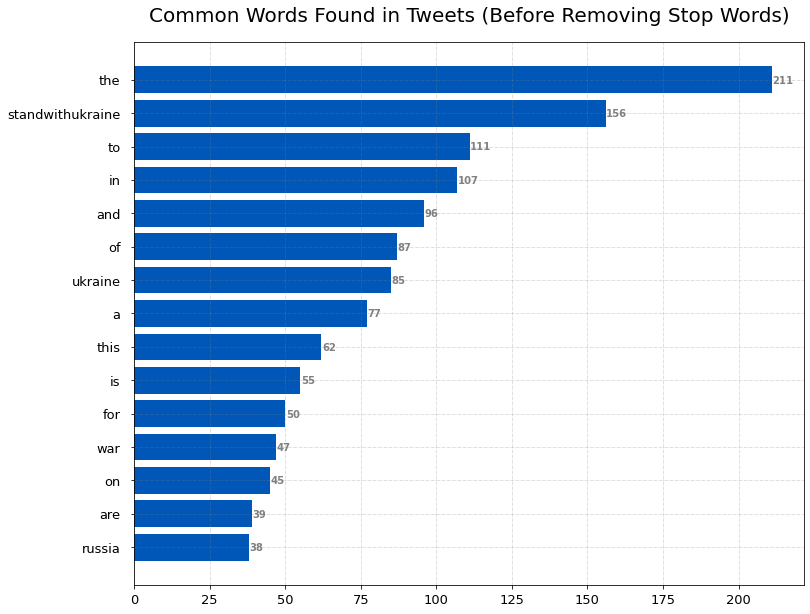

In [10]:
#Replace URLs and @mentions found in a text string with nothing
text_cleaned = tweetsDF['text'].str.replace(r'(@([^\s]+))|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', regex=True).str.strip()
words_in_tweet = [tweet.lower().split() for tweet in text_cleaned] # creating list of individual word from all tweets
words_in_tweet_list = list(itertools.chain(*words_in_tweet)) # flatten into 1 list

# Create counter
counts_words_before = collections.Counter(words_in_tweet_list)

# Creating a dataframe for words in tweets and word count, then sorting by descending order
df_counts_words_before = pd.DataFrame(counts_words_before.items(), columns=["words", "count"]).sort_values(by="count", ascending=False)

# retriving the 15 most common words in tweets
words = df_counts_words_before['words'].head(15)
counts = df_counts_words_before['count'].head(15)

# Figure Size
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal Bar Plot
ax.barh(words, counts, color='#0057b7')

# Add labels and padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=13)
ax.yaxis.set_tick_params(pad=10, labelsize=13)


# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Common Words Found in Tweets (Before Removing Stop Words)', fontsize=20, pad=20)

plt.show()


### After Removing Stop Words

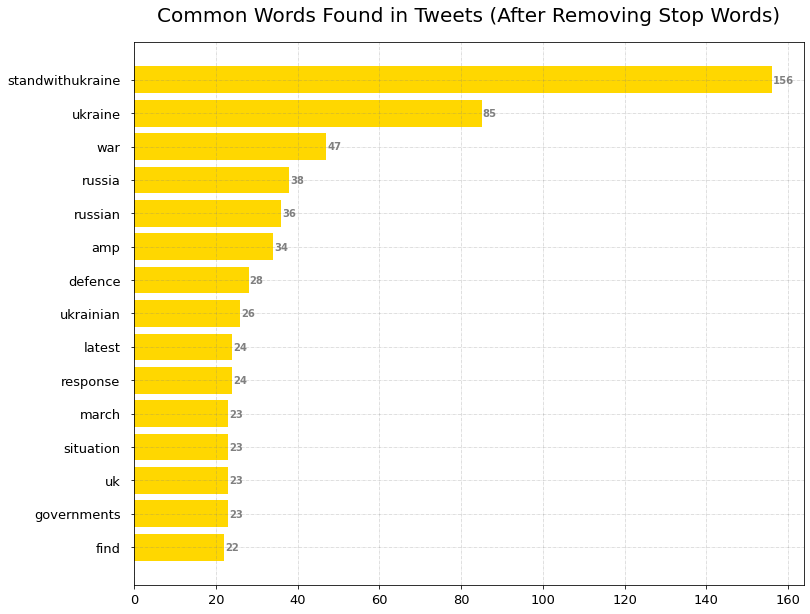

In [11]:
stop_words = set(stopwords.words('english')) # initialising stopwords / commonly used words
# removal of stopwords
tweets_nsw = [[word for word in tweet_words if word not in stop_words]
                for tweet_words in words_in_tweet]  # removing stopwords from list of individual words
all_words = list(itertools.chain(*tweets_nsw)) # flatten into 1 list


# Create counter
counts_words = collections.Counter(all_words)

# Creating a dataframe for words in tweets and word count, then sorting by descending order
df_counts_words_cleaned = pd.DataFrame(counts_words.items(), columns=["words", "count"]).sort_values(by="count", ascending=False)

# retriving the 15 most common words in tweets
words_cleaned = df_counts_words_cleaned['words'].head(15)
counts_cleaned = df_counts_words_cleaned['count'].head(15)

# Figure Size
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal Bar Plot
ax.barh(words_cleaned, counts_cleaned, color="#ffd700")

# Add labels and padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=13)
ax.yaxis.set_tick_params(pad=10, labelsize=13)


# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Common Words Found in Tweets (After Removing Stop Words)', fontsize=20, pad=20)

plt.show()


# Sentimental Analysis - Word Cloud

Note: Please give them a little time to load.

### Creating a generic wordcloud

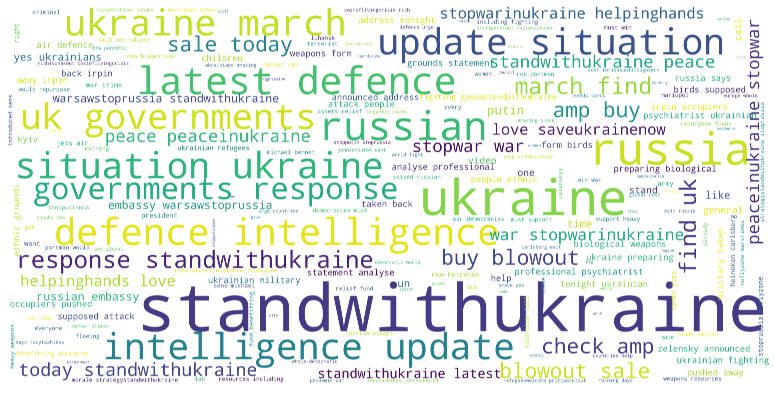

In [12]:
# Generate wordcloud
wordcloud = WordCloud(font_step=1,
                      height=400,
                      width=800,
                      scale=20,
                      stopwords=stop_words, # removes any specified unwanted words
                      background_color='white').generate(' '.join(str(w) for w in all_words)) # collapse list to get string

# Displays the image
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear') # interpolation used to display smoother image
plt.axis("off")
plt.show()


### Creating wordcloud following the map of Ukraine

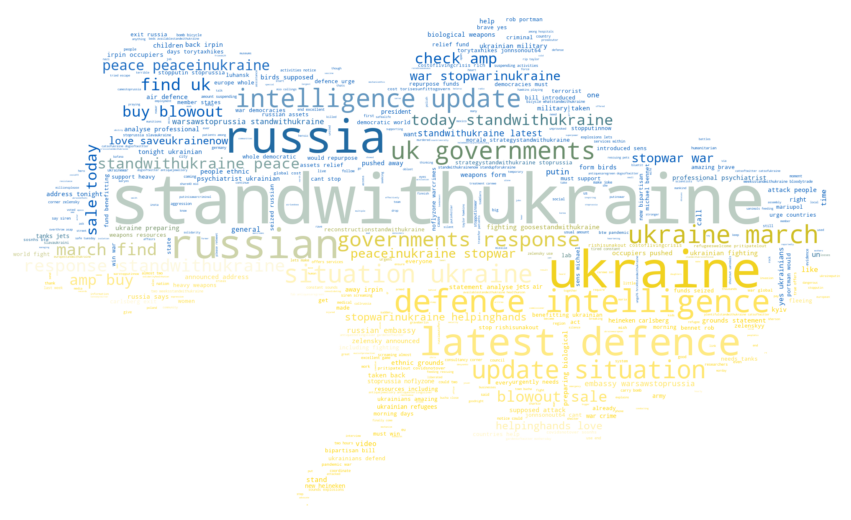

In [16]:
# Generate a word cloud image of Ukraine map
map_mask = np.array(Image.open("ukraine_map.png"))
wordcloud_map = WordCloud(stopwords=stop_words,
                          background_color="white",
                          max_words=500,
                          mode="RGBA",
                          mask=map_mask).generate(' '.join(str(v) for v in all_words))

# create coloring from image
image_colors = ImageColorGenerator(map_mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_map.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("ukraine_map_out.png", format="png")

plt.show()

# Sentimental Analysis - Polarity

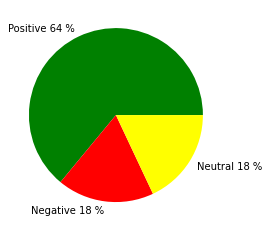

[64, 18, 18]


In [14]:
pos_tweets = 0   #count of positive tweets
neg_tweets = 0   #count of negative tweets
neu_tweets = 0   #count of neutral tweets
total_tweets = 0 #total count of tweets


for polarity in tweetsDF['polarity']:
        total_tweets = total_tweets + 1
        if polarity > 0:
            pos_tweets = pos_tweets + 1
        if polarity == 0:
            neu_tweets = neu_tweets + 1
        if polarity < 0:
            neg_tweets = neg_tweets + 1

tweets_count = [pos_tweets,
                 neg_tweets,
                 neu_tweets]

labels = [ "Positive " + str(round(pos_tweets / total_tweets * 100))+ " %",
            "Negative " + str(round(neg_tweets / total_tweets * 100)) + " %" ,
            "Neutral " + str(round(neu_tweets / total_tweets* 100)) + " %" ]

plt.pie( tweets_count,
labels=labels,
colors=['green','red','yellow']
)
plt.show()

print(tweets_count)